In [1]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import error_analysis

import pandas as pd # type: ignore
import seaborn as sns # type: ignore
from matplotlib import pyplot as plt # type: ignore
plt.style.use('default')
import random
from seaborn.algorithms import bootstrap # type: ignore

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both agents trained in different context granularities.

In [2]:
datasets = ['(3,4)', '(3,8)' ]
n_values = [4, 8]
n_attributes = [3, 3]
n_epochs = 300
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]
print(paths)

['results/(3,4)_game_size_10_vsf_3', 'results/(3,8)_game_size_10_vsf_3']


In [3]:
context_unaware = False # whether original or context_unaware simulations are evaluated
setting = 'standard' # context-aware

granularities = True # wether muliple granularities are evaluated
granularity_list = ['coarse', 'mixed', 'fine']

### Accuracies

### Training trajectories

2


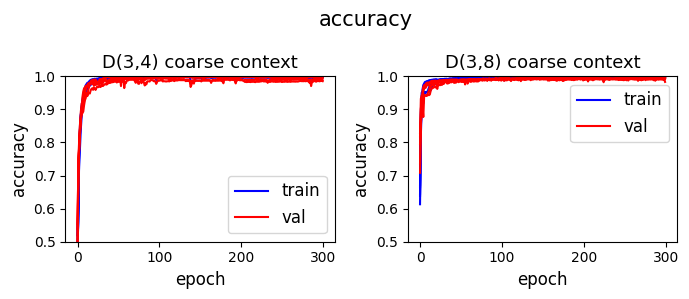

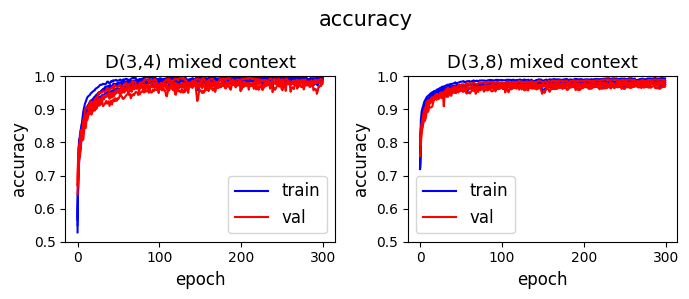

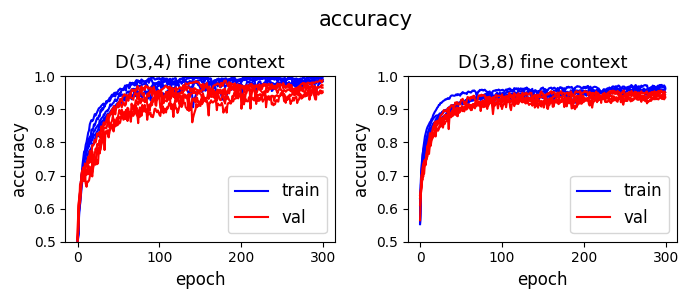

In [4]:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, granularities=True, zero_shot=False, context_unaware=context_unaware)
print(len(all_accuracies['fine_train_acc']))

for g in granularity_list:
    #print(g)
    titles = []
    #print(titles)
    for d in datasets:
        titles.append('D'+ d + ' ' + g + ' context')
    #print(titles)

    plot_training_trajectory(all_accuracies[f'{g}_train_acc'], all_accuracies[f'{g}_val_acc'], 
                               ylim=(0.5, 1), steps=(1, 1), titles = titles, figsize = (7, 3), plot_shape = (1,2))




### Learning speed

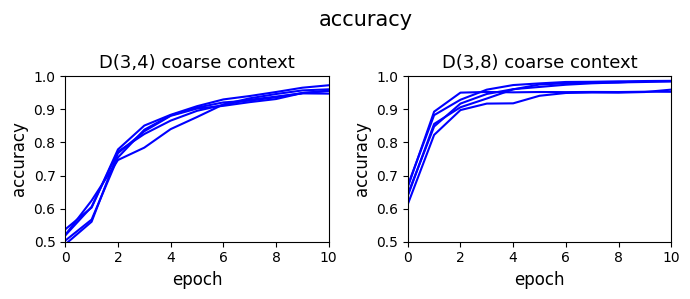

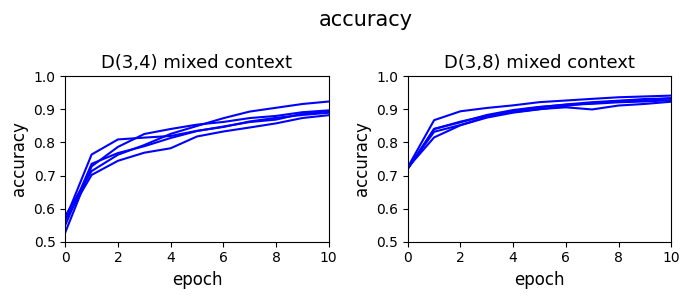

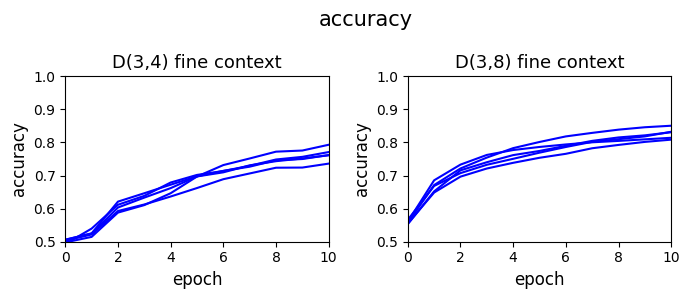

In [5]:

all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, val_steps=1, granularities=True, zero_shot=False, context_unaware=context_unaware)

for g in granularity_list:
    #print(g)
    titles = []
    #print(titles)
    for d in datasets:
        titles.append('D'+ d + ' ' + g + ' context')
    #print(titles)
    plot_training_trajectory(all_accuracies[f'{g}_train_acc'], all_accuracies[f'{g}_val_acc'], 
                               ylim=(0.5, 1), xlim=(0, 10), steps=(1, 1), titles = titles, figsize = (7, 3), plot_shape = (1,2), train_only=True)


plt.show()


### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [6]:
##### heatmap for train and validation with different granularities:
all_accuracies = load_accuracies(paths, n_runs=5, n_epochs=300, granularities = True, val_steps=1, zero_shot=False)
accuracies_grans = []
test_accuracies_grans = []
conds = ['train', 'val']

for g in granularity_list:
    for c in conds:
        accuracies_grans.append(all_accuracies[str(g)+'_' + c + '_acc'])
        #print(all_accuracies[str(g)+'_' + c + '_acc'], '\n\n')


for g in granularity_list:
    test_accuracies_grans.append(all_accuracies[str(g)+'_test_acc'])

#print('granularities',granularity_list)

IndexError: index 2 is out of bounds for axis 0 with size 2

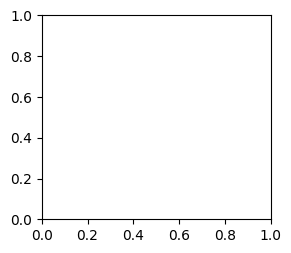

In [13]:
titles = []
conds = ['traning', 'validation']


for g in granularity_list:
        for c in conds:
            titles.append(str(g + ' \n' + c))

plot_heatmap(accuracies_grans, 'mean', plot_dims=(3,2), ylims=(0.4, 1.0), titles = titles, figsize=(6.5, 9), suptitle='Accuracies', 
             fontsize=13)

In [8]:
for gran in granularity_list:
    print(gran + ' granularity: ')

    final_accuracies_train = {}
    final_accuracies_val = {}

    for i, d in enumerate(datasets):
        gather_train_accuracies = []
        gather_val_accuracies = []
        for run in range(5):
            gather_train_accuracies.append(all_accuracies[gran +'_train_acc'][i][run][-1])
            gather_val_accuracies.append(all_accuracies[gran +'_val_acc'][i][run][-1])

        final_accuracies_train[d] = (round(np.mean(gather_train_accuracies), 3), round(np.std(gather_train_accuracies), 3))
        final_accuracies_val[d] = (round(np.mean(gather_val_accuracies), 3), round(np.std(gather_val_accuracies), 3))

    print('final training accuracy:', final_accuracies_train)
    print('final validation accuracy',final_accuracies_val, '\n')


coarse granularity: 
final training accuracy: {'(3,4)': (0.999, 0.002), '(3,8)': (0.999, 0.001)}
final validation accuracy {'(3,4)': (0.992, 0.005), '(3,8)': (0.992, 0.005)} 

mixed granularity: 
final training accuracy: {'(3,4)': (0.993, 0.003), '(3,8)': (0.984, 0.006)}
final validation accuracy {'(3,4)': (0.983, 0.004), '(3,8)': (0.977, 0.006)} 

fine granularity: 
final training accuracy: {'(3,4)': (0.989, 0.004), '(3,8)': (0.961, 0.005)}
final validation accuracy {'(3,4)': (0.966, 0.013), '(3,8)': (0.941, 0.006)} 



#### Accuracies: Boostrapped CIs

In [9]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

bootstrap_means = []

# coarse (train, val), mixed (train, val), fine (train, val)
for i in range(len(accuracies_grans)):
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = [random.choice(accuracies_grans[i]) for _ in range(len(accuracies_grans[i]))]
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
    alpha = (1 - confidence_level) / 2
    lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
    upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
    #for i in bootstrap_means:
    if i % 2 == 0:
        print('train ', end = '')
    elif  i % 2 == 1 :
        print('valid ', end = '')
    if i <= 1:
        print (granularity_list[0] + ': ',  end = '' )
    elif i <= 3 :
        print (granularity_list[1] + ': ', end = '')
    elif i >= 4 :
        print (granularity_list[2] + ': ',  end = '')

    print(f" Bootstrap Confidence Interval ({100*confidence_level}%): ({lower_percentile}, {upper_percentile}), Mean: {np.mean(bootstrap_means)}")

train coarse:  Bootstrap Confidence Interval (95.0%): (0.9914128048419952, 0.9937482643127441), Mean: 0.9925992182531356
valid coarse:  Bootstrap Confidence Interval (95.0%): (0.9863719634215037, 0.9937482643127441), Mean: 0.9900596257215538
train mixed:  Bootstrap Confidence Interval (95.0%): (0.9738715597391129, 0.9937482643127441), Mean: 0.9852298902230726
valid mixed:  Bootstrap Confidence Interval (95.0%): (0.9618952594995499, 0.9937482643127441), Mean: 0.9798528095639993
train fine:  Bootstrap Confidence Interval (95.0%): (0.9352601248025895, 0.9937482643127441), Mean: 0.9726638203102052
valid fine:  Bootstrap Confidence Interval (95.0%): (0.9144807227253914, 0.9937482643127441), Mean: 0.9630152143314811


### Test accuracies
means and stds

In [10]:
test_accuracies_grans

[array([[0.95899999, 0.95620006, 0.917     , 0.94440007, 0.9222002 ],
        [0.98202056, 0.97955483, 0.98842454, 0.99633563, 0.96619874]]),
 array([[0.7956779 , 0.73432183, 0.80398303, 0.83171642, 0.75288135],
        [0.63679951, 0.78210992, 0.73057991, 0.66146594, 0.61986005]]),
 array([[0.60280001, 0.66160005, 0.73200011, 0.59179991, 0.759     ],
        [0.52434933, 0.64352739, 0.52061653, 0.54647261, 0.57256848]])]

In [11]:
for i, d in enumerate(datasets):
    print('\nDataset:', d)
    for g, gran in enumerate(test_accuracies_grans):
        print('Context granularity:', granularity_list[g])
        print('mean:', round(np.mean(gran[i]), 3), ' std:', round(np.std(gran[i]), 3), ' min:', round(np.min(gran[i]), 2), ' max:', round(np.max(gran[i]), 2))


Dataset: (3,4)
Context granularity: coarse
mean: 0.94  std: 0.017  min: 0.92  max: 0.96
Context granularity: mixed
mean: 0.784  std: 0.035  min: 0.73  max: 0.83
Context granularity: fine
mean: 0.669  std: 0.067  min: 0.59  max: 0.76

Dataset: (3,8)
Context granularity: coarse
mean: 0.983  std: 0.01  min: 0.97  max: 1.0
Context granularity: mixed
mean: 0.686  std: 0.061  min: 0.62  max: 0.78
Context granularity: fine
mean: 0.562  std: 0.045  min: 0.52  max: 0.64


## Entropy scores

In [12]:
for g in granularity_list:
    entropy_scores = load_entropies(paths, context_unaware=False, granularity = g) # 
#result_dict[key] = np.array(result_dict[key])
    entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]
    plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(9, 3.5), matrix_indices = ((0,0),),
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle= 'Entropy scores\n' + g + ' context conditon', fontsize = 15)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,8)_game_size_10_vsf_3/standard/granularity_coarse/0/entropy_scores.pkl'

#### Means and stds

In [ ]:
print(list(entropy_scores.keys())[:3])

['NMI', 'effectiveness', 'consistency']


In [ ]:
for g in granularity_list:
    entropy_scores= load_entropies(paths, context_unaware=False, granularity = g) 
    entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]  
    entropy_dict = {}
    for i, score in enumerate(list(entropy_scores.keys())[:3]):
        results = entropies[i]
        mean = np.nanmean(results, axis=-1)
        sd = np.std(results, axis=-1)
        for idx, d in enumerate(datasets):
            entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
    print(g + ' context condition\n', entropy_dict, '\n')

coarse context condition
 {'(3,4)NMI': (0.629, 0.012), '(3,4)effectiveness': (0.472, 0.015), '(3,4)consistency': (0.945, 0.013)} 

mixed context condition
 {'(3,4)NMI': (0.899, 0.014), '(3,4)effectiveness': (0.922, 0.019), '(3,4)consistency': (0.877, 0.012)} 

fine context condition
 {'(3,4)NMI': (0.962, 0.005), '(3,4)effectiveness': (0.977, 0.009), '(3,4)consistency': (0.949, 0.012)} 



#### Bootstraped CIs

In [ ]:
num_bootstrap_samples = 1000  # Number of bootstrap samples
confidence_level = 0.95      # Desired confidence level 

for g in granularity_list:
    entropy_scores= load_entropies(paths, context_unaware=False, granularity = g) 
    entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]  
    entropies_bootstrapped = {}
    bootstrap_means = []

    for i in range(len(entropies)):
        score = list(entropy_scores.keys())[i]
        for idx, d in enumerate(datasets):
            for _ in range(num_bootstrap_samples):
                bootstrap_sample = [random.choice(entropies[i][idx]) for _ in range(len(entropies[i][idx]))]
                bootstrap_mean = np.mean(bootstrap_sample)
                bootstrap_means.append(bootstrap_mean)

            # Calculate the lower and upper percentiles of the bootstrap means to construct the confidence interval
            alpha = (1 - confidence_level) / 2
            lower_percentile = np.percentile(bootstrap_means, 100 * alpha)
            upper_percentile = np.percentile(bootstrap_means, 100 * (1 - alpha))
            #print(f"Bootstrap Confidence Interval ({100*confidence_level}%): ({round(lower_percentile,2)}, {round(upper_percentile,2)}), Mean: {round(np.mean(bootstrap_means),2)}")
            entropies_bootstrapped[d + score] = (round(lower_percentile,2), round(upper_percentile,2)), round(np.mean(bootstrap_means),2)
    print('Bootstrapped Entropies', g, 'context condition')
    print(entropies_bootstrapped)

Bootstrapped Entropies coarse context condition
{'(3,4)NMI': ((0.62, 0.64), 0.63), '(3,4)effectiveness': ((0.46, 0.64), 0.55), '(3,4)consistency': ((0.46, 0.95), 0.68)}
Bootstrapped Entropies mixed context condition
{'(3,4)NMI': ((0.89, 0.91), 0.9), '(3,4)effectiveness': ((0.89, 0.94), 0.91), '(3,4)consistency': ((0.87, 0.93), 0.9)}
Bootstrapped Entropies fine context condition
{'(3,4)NMI': ((0.96, 0.97), 0.96), '(3,4)effectiveness': ((0.96, 0.98), 0.97), '(3,4)consistency': ((0.94, 0.98), 0.96)}


### Concept-dependent

In [ ]:
# from generic to specific
entropy_dict_context_dep = {}

for g in granularity_list:
    entropy_scores= load_entropies(paths, context_unaware=False, granularity = g)   
    entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]

    for i, score in enumerate(list(entropy_scores.keys())[3:6]):
        results = entropies_hierarchical[i]
        mean = np.mean(results, axis=-1)
        #sd = results.std(axis=-1)
        for idx, d in enumerate(datasets):
            entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])
